In [1]:


import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True



In [2]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1) 

    ax.imshow(img)


In [3]:
image = Image.open('notebooks/images/cars.jpg')
image = np.array(image.convert("RGB"))

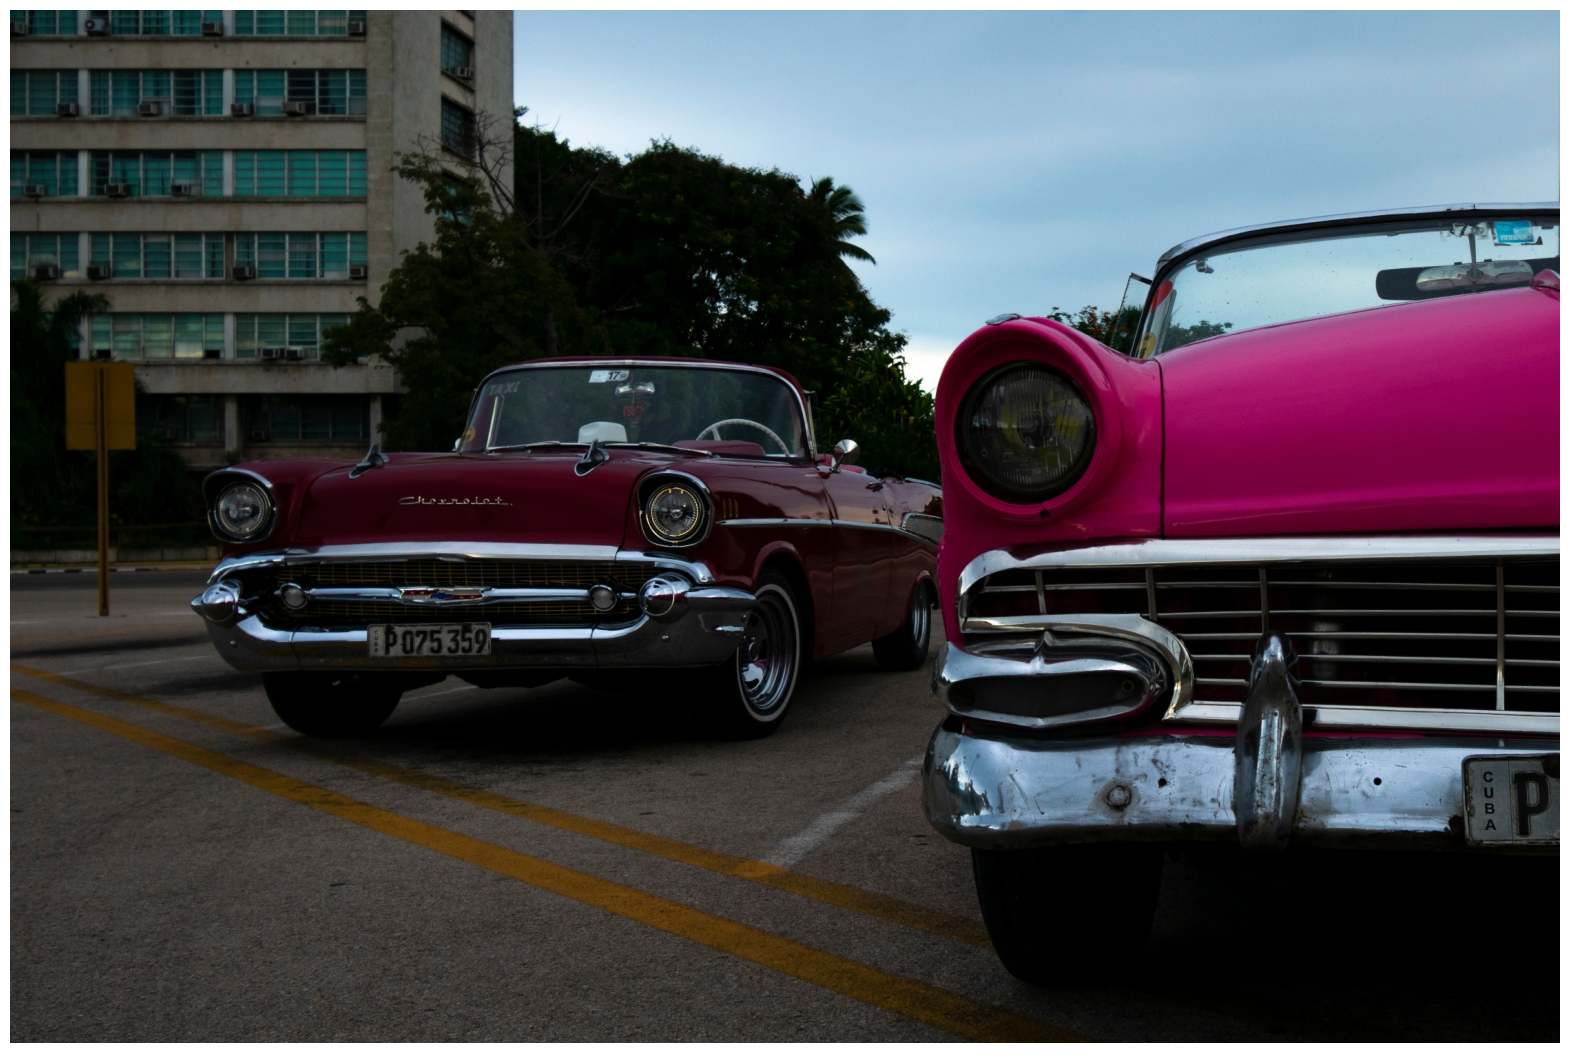

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()


In [5]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device ='cuda', apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [6]:
masks = mask_generator.generate(image)

In [7]:
     

print(len(masks))
print(masks[0].keys())



30
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


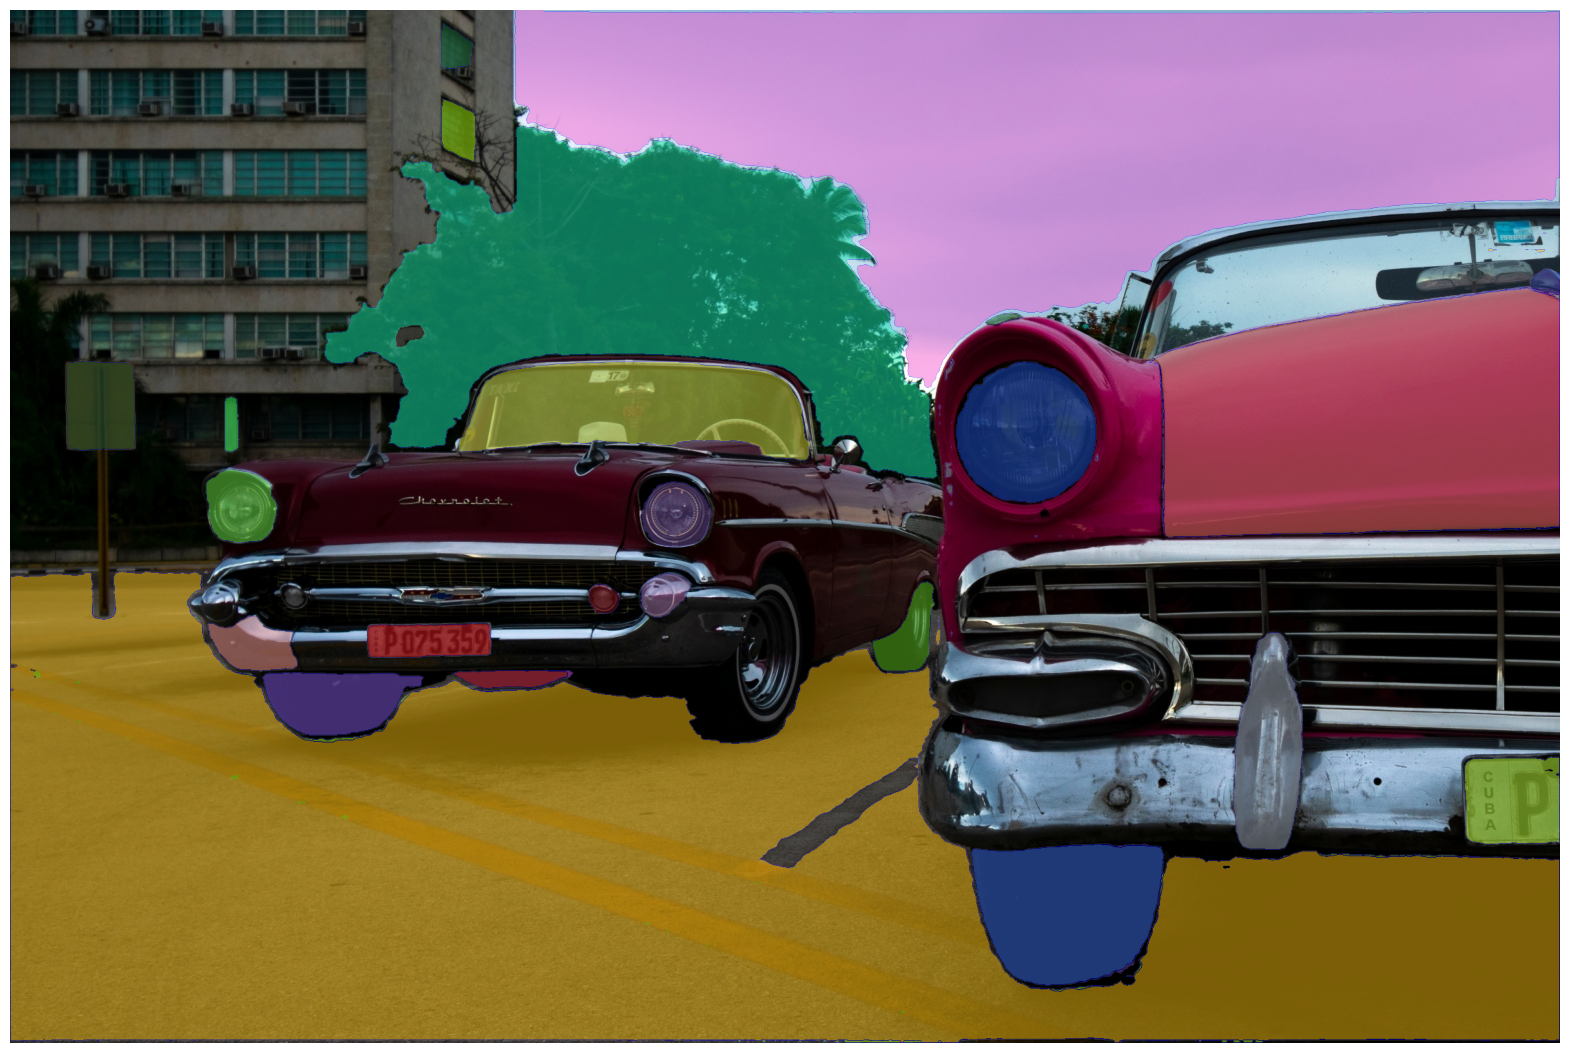

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [ ]:
masks2 = mask_generator_2.generate(image)